In [1]:
import pandas as pd
from sklearn.preprocessing import Imputer, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix
import featuretools as ft
from featuretools import primitives as prims
from featuretools.selection.variance_selection import (
    select_high_variance_features,
    select_percent_null)
import os
from ml import (bin_labels,
                TimeSeriesSplitByDate,
                fit_and_score)
from utils import (build_baseline_features,
                   load_entityset,
                   get_feature_importances,
                   plot_confusion_matrix)
from IPython.display import display
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Using Featuretools to analyze medals won at the Olympic Games

In this notebook, we will examine a dataset containing all the medals won by each athlete at each Summer Olympic Games. Our goal will be to see what quantities are important in predicting the future number of medals won.

To do this, we will build a machine-learning-based predictive model that is trained on historical data, and used to predict the number of medals won by each country in the next Olympics. we'll build this model using high-level transformations of the data-- called features-- that are automatically generated from Featuretools. [Featuretools](https://featuretools.com) is a Python library for [automated feature engineering]().

This notebook will serve as an introduction to Featuretools, but does not explain each API call in depth. Please see the [documentation](https://docs.featuretools.com) for a more thorough usage guide.

## Disclaimer on suitability of the dataset and problem

As we'll see, basic machine learning allows us to predict the particular quantities we care about here extremely well. The advanced high-level features provided by basic Featuretools API calls do not produce that much improvement over our simple baseline model. However, what they do provide are much more interpretable predictive factors, so that we can examine which were factors were most important over time. In the other notebooks in this repo, we will see how to use the more advanced components of Featuretools to both increase our scores and, more importantly, to see how additional types of features affect the predictive power of the model.

In [2]:
ROOT_DATA_FOLDER = os.path.expanduser("~/olympic_games_data")

# Step 1: Load in data

Check out LoadEntityset.ipynb for a walkthrough of how to set up a dataset for use by Featuretools.

`EntitySet` is the in-memory data structure Featuretools uses to build and calculate features. It essentially consists of a dictionary of [Pandas DataFrames](https://pandas.pydata.org/pandas-docs/stable/dsintro.html) with associated metadata on how they are linked, what semantic types they contain, and how they vary in time. For an in-depth guide on. For more details and tutorials, please check out the [documentation](https://docs.featuretools.com/loading_data/using_entitysets.html).

In [3]:
es = load_entityset()
es

Entityset: Olympic Games
  Entities:
    disciplines (shape = [67, 3])
    countries (shape = [220, 8])
    olympic_games (shape = [27, 3])
    medals_won (shape = [11532, 6])
    sports (shape = [43, 2])
    ...And 3 more
  Relationships:
    medaling_athletes.Athlete -> athletes.Athlete
    medals_won.Country Olympic ID -> countries_at_olympic_games.Country Olympic ID
    countries_at_olympic_games.Olympic Games ID -> olympic_games.Olympic Games ID
    medals_won.Discipline -> disciplines.Discipline
    disciplines.Sport -> sports.Sport
    ...and 2 more

## Load labels and cutoff times

Machine learning (in its [supervised](http://scikit-learn.org/stable/supervised_learning.html) flavor) is all about predicting a set of labels, given a set of training data. This is canonically represented by a *feature matrix*, whose rows are each numeric vectors of fixed length. Each row is associated with a single value, called a label. The machine learning algorithm is tasked with building a model that is good at predicting the label given the row vector.

What makes *predictive modeling* more interesting is that the labels actually represent future quantities which we want to predict using historical data. This means that the time associated with the label is extremely important, because we need to know what historical data is valid (we don't want to use data that was recorded *after* the label was known).

In this particular case, our goal is to predict the number of medals won by each country in each subsequent Olympic Games, so our labels will be uniquely defined by a particular country and date of particular Olympic Games in which it competed.

Check out GeneratingLabels.ipynb for a walkthrough of how I generated these labels. Shameless plug: [Feature Labs](https://www.featurelabs.com/), the company that I work for and that maintains Featuretools, sells a platform that, among other things, makes this label generation process extremely easy. This process is known as [Prediction Engineering](https://www.featurelabs.com/resources/why.html).

In [4]:
label_file = os.path.join(ROOT_DATA_FOLDER, "num_medals_by_country_labels.csv")
label_df = pd.read_csv(label_file,
                       parse_dates=['Olympics Date'],
                       encoding='utf-8',
                       usecols=['Number of Medals', 'Olympics Date', 'Country'])
# Sort by the date of the Olympics, and by the country (to maintain a consistent ordering)
label_df.sort_values(['Olympics Date', 'Country'], inplace=True)
label_df.head()

,Number of Medals,Olympics Date,Country
8,2,1896-06-29 00:00:00,AUS
9,5,1896-06-29 00:00:00,AUT
5,6,1896-06-29 00:00:00,DEN
10,11,1896-06-29 00:00:00,FRA
4,7,1896-06-29 00:00:00,GBR


# Generate Features Using Deep Feature Synthesis


Featuretools automatically extracts high-level, interpretable features from EntitySets. This means we can exhaustively create many features, and use these to train our machine learning predictive model.

Moreover, it makes sure to calculate these features only using data on or before specified *cutoff times*. In this case, these cutoff times will be dates immediately prior to each Olympic Games. They are specified in the label file.

In [5]:
# Just want the Country and time to compute features (we're removing the label column here)
cutoff_times = label_df[['Country', 'Olympics Date']]
# Code is the index of the "countries" entity in the entityset (short for Country Code)
cutoff_times = cutoff_times.rename(columns={'Country': 'Code'})

We can specify the particular primitives we want Featuretools to use to construct features. Featuretools will walk through our EntitySet and apply these primitives recursively using the [Deep Feature Synthesis](https://docs.featuretools.com/automated_feature_engineering/afe.html) algorithm. These primitives are basic functions that take a particular data type as input (such as a Numeric or Categorical), and output a single value per *instance* of an entity.

Transform primitives take each instance (row) of an entity and apply a function to each row.

Aggregation primitives take 2 entities, where each row in the *parent* entity is connected to many rows in the *child*, and apply a function to all the rows in the *child* connected to a single *parent* row.


These primitives are defined in more detail [here](https://docs.featuretools.com/automated_feature_engineering/primitives.html)

In [6]:
agg_primitives = [
    prims.Sum, prims.Std, prims.Max, prims.Min, prims.Mean, prims.Count,
    prims.PercentTrue, prims.NUnique, prims.Mode, prims.Trend, prims.Skew
]
trans_primitives = [
    prims.Percentile
]

# Comparison to a Baseline

We want to make sure we use the features we use for our simple baseline model for a fair comparison to our more interpretable Featuretools model. To do this, we define these features manually using Featuretools, and add them in as *seed features* to DFS. This will not only include these features directly, but will also build higher-level features on top of them.

For a more thorough walkthrough of the baseline, check out BaselineSolutions.ipynb.

In [7]:
# Include our baseline predictors as seed features
num_medals_each_olympics, mean_num_medals = build_baseline_features(es)

## Run DFS

A note on the parameter settings:
  * `target_entity` defines the entity containing unique rows (called *instances*) for each training example. 
  * `trans_primitives` is a list of *transform* primitive classes.
  * `agg_primitives` is a list of *aggregation* primitive classes.
  * `max_depth` defines how *deep* we build features on top of one another ([explanation](https://docs.featuretools.com/automated_feature_engineering/afe.html#creating-deep-features))
  * `cutoff_times` is a Pandas DataFrame with a column for defining each instance we want to compute features for, and its associated cutoff time.

In [8]:
feature_matrix, features = ft.dfs(
    entityset=es,
    target_entity="countries",
    trans_primitives=trans_primitives,
    agg_primitives=agg_primitives,
    max_depth=4,
    seed_features=num_medals_each_olympics + [mean_num_medals],
    cutoff_time=cutoff_times,
    verbose=True)

Building features: 2818it [00:03, 552.46it/s] 
Progress: 100%|██████████| 27/27 [23:38<00:00, 110.63s/cutoff time]


# Remove features with zero variance or almost all null

Featuretools contains a couple handy functions for removing features with mostly null values, or with very little variance. Here, we remove the features that have 90% or greater null values, and whose variance (actually [coefficient of variation](https://en.wikipedia.org/wiki/Coefficient_of_variation)) is 0.

In [9]:
feature_matrix, features = select_percent_null(feature_matrix, features, max_null_percent=90)

print "%d low percent null features selected" % len(features)

feature_matrix, features = select_high_variance_features(feature_matrix, features, cv_threshold=0)

print "%d high variance features selected" % len(features)

2399 low percent null features selected
2060 high variance features selected


# One-hot-encode categorical features

Machine learning algorithms require all numeric values as input, but Featuretools by default produces some categorical values. One simple way to transform these values into numbers is to create several binary features that encode whether the feature is equal to each particular category (by default capped at the top 10 most common categories). For more information check out this [docs page](https://docs.featuretools.com/guides/tuning_dfs.html#encoding-categorical-features).

In [10]:
feature_matrix_encoded, features_encoded = ft.encode_features(feature_matrix, features)

# Binarize and bin labels

We'll actually create 3 slightly different models:

  1. Regression. Predicting the actual number of medals per country
  2. Binary Classification. Predicting whether the number of medals is greater than 10.
  3. Binned Classification. Predicting which bin the medals falls into (i.e. between 0 and 2, 2 and 6, 6 and 10, 10 and 50, or greater than 50).

In [11]:
dates = label_df['Olympics Date']
labels = label_df['Number of Medals']
binned_labels, bins = bin_labels(labels, [2, 6, 10, 50])
binary_labels = (labels >= 10).astype(int)

In [12]:
binned_labels.value_counts()

[2.0,6.0)      366
[10.0,50.0)    264
<2.0           246
[6.0,10.0)     141
>=50.0          48
dtype: int64

In [13]:
binary_labels.value_counts()

0    753
1    312
Name: Number of Medals, dtype: int64

## Separate out the baseline features

These are for the slightly more complex, machine-learning-based "Baseline 2" from BaselineSolutions.ipynb. Since the other baseline is not machine-learning-based, refer to that notebook for scores and analysis (they are significantly worse).

In [14]:
just_baseline = feature_matrix_encoded[[
    f.get_name() for f in num_medals_each_olympics
    if f.get_name() in feature_matrix_encoded
]]
just_baseline.tail(10)

,num_medals_olympics_0,num_medals_olympics_1,num_medals_olympics_2,num_medals_olympics_3,num_medals_olympics_4,num_medals_olympics_5,num_medals_olympics_6,num_medals_olympics_7,num_medals_olympics_8,num_medals_olympics_9,...,num_medals_olympics_16,num_medals_olympics_17,num_medals_olympics_18,num_medals_olympics_19,num_medals_olympics_20,num_medals_olympics_21,num_medals_olympics_22,num_medals_olympics_23,num_medals_olympics_24,num_medals_olympics_25
Code,,,,,,,,,,,,,,,,,,,,,
SUI,3.0,6.0,2.0,0.0,0.0,11.0,25.0,14.0,1.0,13.0,...,3.0,3.0,2.0,7.0,2.0,0.0,4.0,6.0,1.0,4.0
SVK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0,6.0,5.0
SWE,0.0,1.0,0.0,21.0,62.0,58.0,28.0,22.0,23.0,20.0,...,12.0,5.0,8.0,14.0,6.0,9.0,5.0,7.0,6.0,4.0
THA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,3.0,8.0,4.0
TPE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,5.0,4.0,2.0
TUN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
TUR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,1.0,0.0,0.0,2.0,2.0,6.0,6.0,5.0,9.0,6.0
UKR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,18.0,11.0,16.0,23.0
USA,19.0,46.0,232.0,44.0,60.0,84.0,83.0,42.0,83.0,47.0,...,64.0,58.0,0.0,128.0,57.0,75.0,65.0,62.0,64.0,67.0


# Build machine learning models and generate scores

## Create scikit-learn estimators

We'll use stock machine learning algorithms from scikit-learn, as well as an imputer that replaces missing values with the mean over that feature, and a scaler that makes sure each feature's values vary from 0 to 1. The `RobustScaler` class is more sensitive to outliers than the `StandardScaler`.

In [40]:
pipeline_preprocessing = [("imputer",
                           Imputer(missing_values='NaN', strategy="mean", axis=0)),
                          ("scaler", RobustScaler(with_centering=True))]
rf_reg = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

# Time-based cross-validation

The way we'll do cross-validation is to separate training sets for each Olympics since 1960, using all historical data in the past for each.

In [16]:
splitter = TimeSeriesSplitByDate(dates=dates, earliest_date=pd.Timestamp('1/1/1960'))

In [17]:
X = feature_matrix_encoded.values
y = labels.values
y_binary = binary_labels.values
y_binned = binned_labels.values
X_baseline = just_baseline.values

### Modeling

`fit_and_score` takes in a feature matrix, labels, splitter, and the machine learning pipeline, builds models for each split, and scores each one using various metrics.

In [18]:
reg_pipeline = Pipeline(pipeline_preprocessing + [("rf_reg", rf_reg)])
scores = fit_and_score(X, y, splitter, reg_pipeline, _type='regression')
baseline_scores = fit_and_score(X_baseline, y, splitter, reg_pipeline, _type='regression')
print "Regression model"
print "  R2 mean score:  %.2f +/- %.2f" % (scores['r2'].mean(),
                                           scores['r2'].std())
print "  Baseline R2 mean score:  %.2f +/- %.2f" % (baseline_scores['r2'].mean(),
                                                    baseline_scores['r2'].std())
print "  MSE mean score:  %.2f +/- %.2f" % (scores['mse'].mean(),
                                            scores['mse'].std())
print "  Baseline MSE mean score:  %.2f +/- %.2f" % (baseline_scores['mse'].mean(),
                                                         baseline_scores['mse'].std())

Regression model rf_regression
  R2 mean score:  0.76 +/- 0.15
  Baseline R2 mean score:  0.78 +/- 0.15
  MSE mean score:  74.40 +/- 56.51
  Baseline MSE mean score:  70.11 +/- 56.20


In [19]:
pipeline = Pipeline(pipeline_preprocessing + [('rf_clf', rf_clf)])
binary_scores = fit_and_score(X, y_binary, splitter, pipeline, _type='classification')
baseline_binary_scores = fit_and_score(X_baseline, y_binary, splitter, pipeline, _type='classification')
binned_scores = fit_and_score(X, y_binned, splitter, pipeline, _type='classification')
baseline_binned_scores = fit_and_score(X_baseline, y_binned, splitter, pipeline, _type='classification')
print "Classification model"
print "  AUC mean score:  %.2f +/- %.2f" % (binary_scores['roc_auc'].mean(),
                                            binary_scores['roc_auc'].std())
print "  Baseline AUC mean score:  %.2f +/- %.2f" % (baseline_binary_scores['roc_auc'].mean(),
                                                     baseline_binary_scores['roc_auc'].std())
print "  F1 mean score:  %.2f +/- %.2f" % (binary_scores['f1'].mean(),
                                           binary_scores['f1'].std())
print "  Baseline F1 mean score:  %.2f +/- %.2f" % (baseline_binary_scores['f1'].mean(),
                                                    baseline_binary_scores['f1'].std())
print "  Binned F1 (micro averaged) mean score:  %.2f +/- %.2f" % (binned_scores['f1_micro'].mean(),
                                                                   binned_scores['f1_micro'].std())
print "  Baseline Binned F1 (micro averaged) mean score:  %.2f +/- %.2f" % (baseline_binned_scores['f1_micro'].mean(),
                                                                            baseline_binned_scores['f1_micro'].std())

Classification model rf_clf
  AUC mean score:  0.95 +/- 0.04
  Baseline AUC mean score:  0.94 +/- 0.02
  F1 mean score:  0.82 +/- 0.08
  Baseline F1 mean score:  0.81 +/- 0.08
  Binned F1 (micro averaged) mean score:  0.59 +/- 0.09
  Baseline Binned F1 (micro averaged) mean score:  0.59 +/- 0.09


# Comparing scores across years

We'll plot the scores over time for each type of problem, and then look at a few confusion matrices for particular years.

### Plotting the regression scores

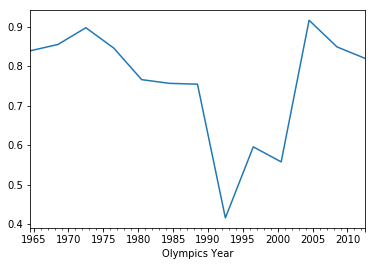

In [24]:
scores.set_index('Olympics Year')['r2'].plot()

### Plotting the binned scores


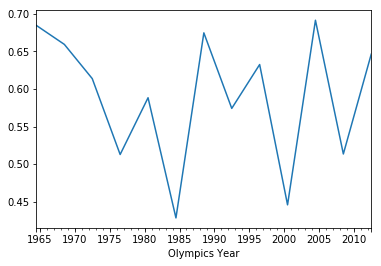

In [23]:
binned_scores.set_index('Olympics Year')['f1_micro'].plot()

### Plotting the binary scores

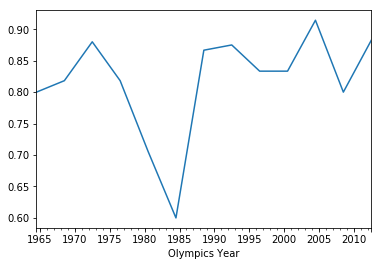

In [27]:
binary_scores.set_index('Olympics Year')['f1'].plot()

Notice how the binned problem is harder in different years than the regression problem. 1984 is a terrible year for the binned predictor, while 1992 is much worse for the regression predictor. The binary score is on the whole smoother over time, but still has a major hiccup in 1984.

In [28]:
binary_scores

,f1,roc_auc,Olympics Year
0,0.800000,0.902244,1964-06-29
1,0.818182,0.854167,1968-06-29
2,0.880000,0.977667,1972-06-29
3,0.818182,0.966667,1976-06-29
4,0.705882,0.958333,1980-06-29
5,0.600000,0.934949,1984-06-29
6,0.866667,0.985222,1988-06-29
7,0.875000,0.945988,1992-06-29
8,0.833333,0.938776,1996-06-29
9,0.833333,0.949901,2000-06-29


## Confusion Matrices

The confusion matrix is a good way to quickly see well a model is predicting binary outcomes. For an intro to what these are, see Scikit-Learn's [User Guide](http://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix).
Let's plot the confusion matrix for 1984 (a hard-to-predict year) and 2004 (an easy-to-predict year) (using code taken from Scikit-Learn [here](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py))

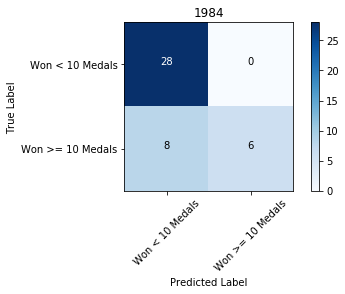

In [32]:
# 1984 = 5th split
split, year = 5, '1984'
train, test = splitter.split(X, y_binary)[split]
pipeline.fit(X[train], y_binary[train])
y_pred = pipeline.predict(X[test])
cm = confusion_matrix(y_binary[test], y_pred)
plot_confusion_matrix(cm, ['Won < 10 Medals', 'Won >= 10 Medals'], title=year)

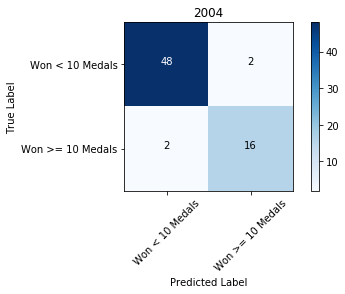

In [33]:
# 2004 = 10th split
split, year = 10, '2004'
train, test = splitter.split(X, y_binary)[split]
pipeline.fit(X[train], y_binary[train])
y_pred = pipeline.predict(X[test])
cm = confusion_matrix(y_binary[test], y_pred)
plot_confusion_matrix(cm, ['Won < 10 Medals', 'Won >= 10 Medals'], title=year)

In 1984, we underestimated how many medals 8 countries scored, while in 2004, we underestimated only 2 countres and overestimated 2. As we'll see later, this is probably due to the boycott in 1984 by Soviet Bloc countries, leading to higher medals scored by the democratic nations like the USA.

## Comparison to baseline

We actually do almost exactly the same as our baseline. The reason for this is most likely that this is in general a very easy problem, yet for particular cases is a very hard problem for which additional data is needed to make better predictions.

However, our interpretable features now provide us with a way to examine which hidden factors are the most predictive of the outcome. The baseline features are essentially uninterpretable- they are simply the number of medals scored at each prior Olympic Games.

# Examine feature importances

This utility function grabs the Scikit-Learn Random Forest's built in feature importances, sorts them, and groups them by time split. These refer to how important each feature was in predicting the label.

We'll print out the top 10 most predictive features for each Olympics since 1960.

In [34]:
feature_imps_over_time = get_feature_importances(pipeline,
                                                 feature_matrix_encoded,
                                                 binary_labels,
                                                 splitter,
                                                 n=400)

In [35]:
for date, fi in sorted(feature_imps_over_time.items(), key=lambda x: x[0]):
    print "Test year: %s" % date.year
    print "Top 10 feats:"
    for f in fi['Feature'][:10]:
        print "   ", f

Test year: 1964
Top 10 feats:
    MAX(countries_at_olympic_games.PERCENTILE(NUM_UNIQUE(medals_won.Event)))
    PERCENTILE(SUM(medals_won.disciplines.NUM_UNIQUE(medaling_athletes.Athlete)))
    MEAN(countries_at_olympic_games.PERCENTILE(NUM_UNIQUE(medals_won.MODE(medaling_athletes.Athlete))))
    MAX(countries_at_olympic_games.PERCENTILE(SKEW(medals_won.COUNT(medaling_athletes))))
    MEAN(countries_at_olympic_games.PERCENTILE(COUNT(medals_won WHERE Medal = Gold)))
    MEAN(countries_at_olympic_games.COUNT(medals_won WHERE Medal = Gold))
    MEAN(countries_at_olympic_games.PERCENTILE(NUM_UNIQUE(medals_won.Discipline)))
    PERCENTILE(MEAN(countries_at_olympic_games.SUM(medals_won.NUM_UNIQUE(medaling_athletes.Athlete))))
    PERCENTILE(MAX(countries_at_olympic_games.COUNT(medals_won WHERE Medal = Gold)))
    MIN(countries_at_olympic_games.countries.mean_num_medals)
Test year: 1968
Top 10 feats:
    PERCENTILE(COUNT(medals_won WHERE Medal = Gold))
    MEAN(countries_at_olympic_games.PERCE

We see that features built on Baseline 1 ("mean_num_medals") are pretty high up in the list, but we do some interesting transformations on them. In particular, the Percentile feature is important across the board.

We will examine particular features and what they mean in more depth later on.

# Supervised Feature Selection

One interesting workflow that Featuretools allows is the ability to select the most important features from an exhaustive list based on which were actually useful in predicting the labels.

To do this, let's rerun the computation using just the top 400 features

In [42]:
top400 = feature_imps_over_time[pd.Timestamp('6/29/2012')]['Feature'].tolist()
important_feature_matrix = feature_matrix[top400]

pipeline = Pipeline(pipeline_preprocessing + [('rf_clf', rf_clf)])
binned_scores = fit_and_score(important_feature_matrix.values, y_binned, splitter, pipeline, _type='classification')
print "  F1 micro mean score:  %.2f +/- %.2f" % (scores['f1_micro'].mean(),
                                                 scores['f1_micro'].std())

  F1 micro mean score:  0.60 +/- 0.08


# Comparison to full feature set

We do ever so slightly better than our original model. However, in absolute terms our scores did not change very much. What's more interesting is that we now have a smaller set of highly explainable features. We can reduce this feature set even more without a drop in accuracy. Here it is with 50 features.

In [44]:
important_feature_matrix = feature_matrix[top400[:50]]
pipeline = Pipeline(pipeline_preprocessing + [('rf_clf', rf_clf)])
binned_scores = fit_and_score(important_feature_matrix.values, y_binned, splitter, pipeline, _type='classification')
print "  F1 micro mean score:  %.2f +/- %.2f" % (scores['f1_micro'].mean(),
                                                 scores['f1_micro'].std())

  F1 micro mean score:  0.60 +/- 0.08


## Smaller set of important features

Now let's take a closer look at the important features

In [45]:
feature_imps_over_time = get_feature_importances(pipeline,
                                                 important_feature_matrix,
                                                 binary_labels,
                                                 splitter,
                                                 n=50)

for date, fi in sorted(feature_imps_over_time.items(), key=lambda x: x[0]):
    print "Test year: %s" % date.year
    print "Top 10 feats:"
    for f in fi['Feature'][:50]:
        print "   ", f

Test year: 1964
Top 10 feats:
    PERCENTILE(COUNT(medals_won WHERE Medal = Gold))
    MEAN(countries_at_olympic_games.PERCENTILE(COUNT(medals_won WHERE Medal = Gold)))
    MEAN(countries_at_olympic_games.PERCENTILE(COUNT(medals_won)))
    MEAN(countries_at_olympic_games.PERCENTILE(NUM_UNIQUE(medals_won.Event)))
    MEAN(countries_at_olympic_games.PERCENTILE(NUM_UNIQUE(medals_won.MODE(medaling_athletes.Athlete))))
    MEAN(countries_at_olympic_games.SKEW(medals_won.NUM_UNIQUE(medaling_athletes.athletes.Gender)))
    MAX(countries_at_olympic_games.SKEW(medals_won.NUM_UNIQUE(medaling_athletes.Athlete)))
    MEAN(countries_at_olympic_games.PERCENTILE(COUNT(medaling_athletes)))
    MAX(countries_at_olympic_games.PERCENTILE(COUNT(medals_won WHERE Medal = Gold)))
    MEAN(countries_at_olympic_games.SUM(medals_won.NUM_UNIQUE(medaling_athletes.athletes.Gender)))
    TREND(countries_at_olympic_games.PERCENTILE(NUM_UNIQUE(medals_won.MODE(medaling_athletes.Athlete))), Year)
    PERCENTILE(MEAN(co

Now we see some interesting thins.

For one, the important features make a lot of sense. For 1964, the most important feature is `PERCENTILE(COUNT(medals_won WHERE Medal = Gold))`. This refers to the percentile across all countries of the count of gold medals won in all previous Olympics.

The top feature in 1976 is more complicated but makes sense once we parse it. It's `MEAN(countries_at_olympic_games.PERCENTILE(NUM_UNIQUE(medals_won.MODE(medaling_athletes.Athlete))))`. This is a convoluted way of saying take the number of unique medaling athletes at each olympics a country competed in, find the percentile of that number in relation to the other countries, and take the average percentile over time. In other words, the average rank of the number of medaling athletes over time. The Mode part is an overcomplication that does not provide any additional information. So, if this value was high, it means that the country had on average a lot of medaling athletes in its historical Olympic showings.

In 2012, a few features down we have `TREND(countries_at_olympic_games.SKEW(medals_won.NUM_UNIQUE(medaling_athletes.Athlete)), Year)`. The way we have out data set up, each medal can be associated with many athletes (think: all the members of the medaling Soccer team). Therefore, this feature is looking at the skew (a statistical measure indicating whether more of the values lie toward the left or the right of the mean) of how many athletes there were per medal, and finding the the slope of a trend line fitted these skew numbers over time. One way to think of the skew number is whether the country won more medals in team sports than in individual sports, and the trend shows how that changes over time.

## Why were some years difficult to predict?
Specifically, the years between 1970 and 1992 showed high variability in scores.

The Olympics in the 1980s were marred by controversies. Summarizing the
[Wikipedia article](https://en.wikipedia.org/wiki/List_of_Olympic_Games_scandals_and_controversies):
1. Rule changes
   - This is the period that the IOC gradually started allowing professional
   athletes
2. Geopolitics
   - Widespread boycotts due to the Cold War
   - Montreal 1976: 22 African nations boycotted (to protest New Zealand's
   rugby team's tour of South Africa during Apartheid). China and Taiwan both
   boycotted. Fewest number of countries (92) participating since 1960.
   - Moscow 1980: US boycotts because of Soviet invasion of Afghanistan.
      Even fewer number of countries (80) than 1976
   - Los Angeles 1984: Soviet Union and 15 Eastern Bloc nations boycott
   because of "safety concerns". (However, a record 140 National Olympic
   Committees took part)
      Even fewer number of countries (80) than 1976
3. Performance-enhancing Drugs
   - late 1970s and especially 1980s ushered in the era of steroids
   - quote from 1989 Australian study "There is hardly a medal winner at the
   Moscow Games, certainly not a gold medal winner, who is not on one sort of
   drug or another: usually several kinds. The Moscow Games might as well have
   been called the Chemists' Games." See the wiki
   [page](https://en.wikipedia.org/wiki/Olympic_Games#Use_of_performance-enhancing_drugs), citation 183.
4. Gender discrimination
   - Many countries didn't send women until the late 1990s

[Coming Soon] For a more in-depth analysis, check out AdvancedFeaturetools.ipynb and LinkingDatasets.ipynb

# Let's make a prediction about the 2016 olympics

We've trained models to predict the highest medaling countries in past Olympic Games, so we might as well use those models to predict who will receive the most medals in the next Olympics. This dataset came out before 2016, so we can compare to what actually happened. Unfortunately, the way our model is set up we would have to add in the 2016 data to make predictions about 2020 (I'll leave that up to you to try out yourself).

Progress: 100%|██████████| 1/1 [00:20<00:00, 20.82s/cutoff time]


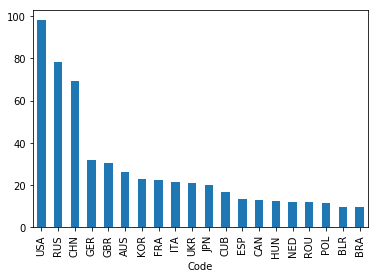

In [46]:
# Train on all data
reg_pipeline.fit(important_feature_matrix, y)

# Get the top feature objects to compute
important_features = {f.get_name(): f for f in features_encoded
                      if f.get_name() in important_feature_matrix.columns}.values()
# Compute feature matrix on all data (no cutoff time)
# Leave cutoff_date blank to use the current time
df = es['countries_at_olympic_games'].df
countries_2012 = df.loc[df['Year'] == pd.Timestamp('2012-06-30'), 'Country']
latest_fm = ft.calculate_feature_matrix(features=important_features,
                                        instance_ids=countries_2012,
                                        cutoff_time=None,
                                        verbose=True)
# Make sure order is correct
latest_fm = latest_fm[important_feature_matrix.columns]

predictions = reg_pipeline.predict(latest_fm)
predictions_by_country = pd.Series(predictions, index=latest_fm.index)
predictions_by_country.sort_values(ascending=False, inplace=True)
predictions_by_country.head(20).plot(kind='bar')

The actual medal count is available [here](https://en.wikipedia.org/wiki/2016_Summer_Olympics_medal_table).
I took the first 20 to plot:

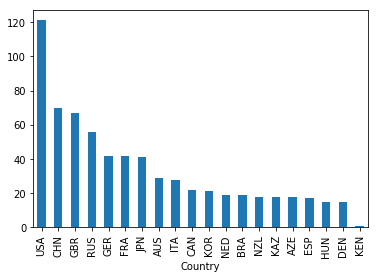

In [47]:
actual_2016 = pd.DataFrame.from_records([('USA', 121),
('CHN', 70) ,
('GBR', 67) ,
('RUS', 56) ,
('GER', 42) ,
('FRA', 42) ,
('JPN', 41) ,
('AUS', 29) ,
('ITA', 28) ,
('CAN', 22) ,
('KOR', 21) ,
('NED', 19) ,
('BRA', 19) ,
('NZL', 18) ,
('KAZ', 18) ,
('AZE', 18) ,
('ESP', 17) ,
('HUN', 15) ,
('DEN', 15) ,
('KEN', 1)], columns=['Country', 'Medals']).set_index(['Country'])['Medals']

actual_2016.plot(kind='bar')

Looks like we overestimated Russia and underestimated Great Britain and China!

However- recall that in this past Olympics Russia was implicated in a major state-sponsored doping scandal. This resulted in the disqualification of essentially the entire track & field team. So Russia would otherwise probably have score many more medals.

# More wildness
What happens if we include all historical countries that ever competed?

Progress: 100%|██████████| 1/1 [00:26<00:00, 26.35s/cutoff time]


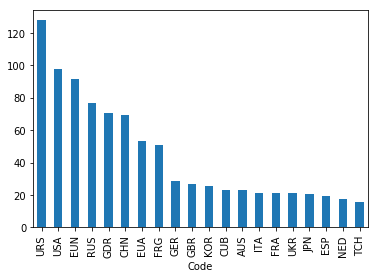

In [48]:
# Leave instance_ids blank to use all
latest_fm = ft.calculate_feature_matrix(features=important_features,
                                        cutoff_time=None,
                                        verbose=True)
# Make sure order is correct
latest_fm = latest_fm[important_feature_matrix.columns]

predictions = reg_pipeline.predict(latest_fm)
predictions_by_country = pd.Series(predictions, index=latest_fm.index)
predictions_by_country.sort_values(ascending=False, inplace=True)
predictions_by_country.head(20).plot(kind='bar')

Our model thinks that if the former Soviet Union were alive today it would win it all!